# XGBoost Modeling for Employee Attrition

This notebook implements an end-to-end workflow for predicting employee attrition using XGBoost, including feature engineering, model training, evaluation, and interpretability.

---

## Imports

We begin by importing essential libraries for data manipulation, visualization, and evaluation.

In [100]:
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split, cross_validate

import xgboost as xgb
from sklearn.model_selection import GridSearchCV
import shap

## Data Loading

Load the cleaned HR employee attrition dataset for modeling. 

In [101]:
# Load the dataset
file_path = '../resources/data/output/hr_employee_attrition_prepared.csv'
df = pd.read_csv(file_path)

In [102]:
df.head()

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EnvironmentSatisfaction,Gender,...,PerformanceRating,RelationshipSatisfaction,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,2,Female,...,3,1,0,8,0,1,6,4,0,5
1,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,3,Male,...,4,4,1,10,3,3,10,7,1,7
2,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,4,Male,...,3,2,0,7,3,3,0,0,0,0
3,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,4,Female,...,3,3,0,8,3,3,8,7,3,0
4,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,Male,...,3,4,1,6,3,3,2,2,2,2


In [103]:
df.shape

(1470, 31)

## Functions

The following helper functions are used for model evaluation and visualization:
- **plot_roc_curve**: Plots ROC curve and computes AUC for model discrimination.
- **plot_confusion_matrix**: Visualizes confusion matrix as a heatmap.
- **plot_metrics_comparison**: Compares base and tuned model metrics visually.

In [104]:
def plot_roc_curve(y_true, y_pred_proba):
    """
    Computes and plots the Receiver Operating Characteristic (ROC) curve.

    Args:
        y_true (array-like): True binary labels.
        y_pred_proba (array-like): Predicted probabilities for the positive class.
    """
    # Compute ROC curve and ROC area
    fpr, tpr, thresholds = roc_curve(y_true, y_pred_proba)
    roc_auc = auc(fpr, tpr)

    # Plot ROC curve
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate (FPR)')
    plt.ylabel('True Positive Rate (TPR)')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.show()

In [105]:
def plot_confusion_matrix(y_true, y_pred, class_labels=['stay', 'left']):
    """
    Computes and plots a confusion matrix as a heatmap.

    Args:
        y_true (array-like): True binary labels.
        y_pred (array-like): Predicted binary labels.
        class_labels (list, optional): The labels for the classes. 
                                     Defaults to ['stay', 'left'].
    """
    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    
    # Plot confusion matrix heatmap
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=class_labels,
                yticklabels=class_labels)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

In [106]:

def plot_metrics_comparison(report_base, report_tuned, roc_auc_base, roc_auc_tuned):
    """
    Compares and plots classification metrics for base and tuned models using Seaborn.

    Args:
        report_base (dict): Classification report for the base model.
        report_tuned (dict): Classification report for the tuned model.
        roc_auc_base (float): ROC AUC score for the base model.
        roc_auc_tuned (float): ROC AUC score for the tuned model.
    """
    # 1. Prepare the data in a long-form DataFrame
    metrics_data = []
    metrics_to_plot = ['precision', 'recall', 'f1-score']
    
    # Extract scores for the positive class
    for metric in metrics_to_plot:
        metrics_data.append({'Model': 'Base Model', 'Metric': metric, 'Score': report_base['1'][metric]})
        metrics_data.append({'Model': 'Tuned Model', 'Metric': metric, 'Score': report_tuned['1'][metric]})
    
    # Add ROC AUC scores
    metrics_data.append({'Model': 'Base Model', 'Metric': 'roc_auc', 'Score': roc_auc_base})
    metrics_data.append({'Model': 'Tuned Model', 'Metric': 'roc_auc', 'Score': roc_auc_tuned})
    
    df = pd.DataFrame(metrics_data)

    # 2. Create the plot using Seaborn
    plt.figure(figsize=(10, 6))
    ax = sns.barplot(data=df, x='Metric', y='Score', hue='Model', palette='viridis')

    # 3. Add score labels on top of each bar
    for p in ax.patches:
        ax.annotate(f'{p.get_height():.3f}', 
                    (p.get_x() + p.get_width() / 2., p.get_height()), 
                    ha='center', va='center', 
                    xytext=(0, 9), 
                    textcoords='offset points')

    # 4. Final plot adjustments
    ax.set_ylim(0, 1.1)
    ax.set_ylabel('Score')
    ax.set_xlabel('Metric')
    ax.set_title('Comparison of Classification Metrics (Base vs. Tuned Model)')
    plt.legend(title='Model')
    plt.tight_layout()
    plt.show()

## Feature Engineering

In this section, we prepare and engineer features for our XGBoost model based on the predictive power guidance provided.

### Objectives:
- Select features with high and moderate predictive power.
- Handle missing values appropriately.
- Encode ordinal and categorical features.
- Create interaction features where relevant.
- Prepare the final dataset for modeling.

---

### Feature Selection Rationale:

**Continuous Features Included:**  
- Strong signal: MonthlyIncome, TotalWorkingYears, Age, YearsAtCompany, YearsInCurrentRole, YearsWithCurrManager  
- Moderate signal: NumCompaniesWorked  

**Continuous Features Dropped:**  
- DistanceFromHome, DailyRate, HourlyRate, MonthlyRate, TrainingTimesLastYear, YearsSinceLastPromotion (low signal)

**Ordinal Features Included:**  
- EnvironmentSatisfaction, JobInvolvement, JobLevel, JobSatisfaction, StockOptionLevel, WorkLifeBalance, RelationshipSatisfaction  

**Ordinal Features Dropped:**  
- Education, PerformanceRating (low signal)

**Categorical Features Included:**  
- OverTime, BusinessTravel, MaritalStatus, JobRole  

**Categorical Moderate:**  
- Department  

**Categorical Features Dropped:**  
- Gender, EducationField (low signal)

---

### Handling Missing Values:

XGBoost can inherently handle missing values during training; however, imputing missing values can sometimes improve performance and stability.  
- Continuous and ordinal features are imputed with median values.  
- Categorical features are imputed with mode (most frequent value).  

---

### Encoding Strategy:

- Ordinal features are encoded as integers preserving their natural order.  
- Categorical features are encoded using Label Encoding to convert categories into numeric labels.


In [107]:
# Define features according to guidance

# Continuous features to include
continuous_include = [
    'MonthlyIncome', 'TotalWorkingYears', 'Age', 'YearsAtCompany',
    'YearsInCurrentRole', 'YearsWithCurrManager'
]

# Continuous feature with moderate signal
continuous_moderate = ['NumCompaniesWorked']

# Ordinal features to include
ordinal_include = [
    'EnvironmentSatisfaction', 'JobInvolvement', 'JobLevel',
    'JobSatisfaction', 'StockOptionLevel', 'WorkLifeBalance',
    'RelationshipSatisfaction'
]

# Categorical features to include
categorical_include = ['OverTime', 'BusinessTravel', 'MaritalStatus', 'JobRole']

# Categorical feature with moderate signal
categorical_moderate = ['Department']

# Combine all selected features
features_to_keep = continuous_include + continuous_moderate + ordinal_include + categorical_include + categorical_moderate

# Filter dataset to selected features
df_features = df[features_to_keep].copy()

# Handle missing values

# Impute continuous and ordinal features with median
for col in continuous_include + continuous_moderate + ordinal_include:
    if df_features[col].isnull().sum() > 0:
        median_val = df_features[col].median()
        df_features[col].fillna(median_val, inplace=True)

# Impute categorical features with mode
for col in categorical_include + categorical_moderate:
    if df_features[col].isnull().sum() > 0:
        mode_val = df_features[col].mode()[0]
        df_features[col].fillna(mode_val, inplace=True)

# Ensure ordinal features are integer type
for col in ordinal_include:
    df_features[col] = df_features[col].astype(int)

# Define categorical features
categorical_nominal = ['MaritalStatus', 'JobRole', 'Department']

# Define which are ordinal or binary 
categorical_ordinal_binary = ['OverTime', 'BusinessTravel'] 

# Encode categorical features using LabelEncoder
label_encoders = {}
for col in categorical_ordinal_binary:
    le = LabelEncoder()
    df_features[col] = le.fit_transform(df_features[col])
    label_encoders[col] = le  # Save for inverse transform or future use

# Apply One-Hot Encoding to the nominal features
df_features = pd.get_dummies(df_features, columns=categorical_nominal, prefix=categorical_nominal)


In [108]:
print("Final feature columns:", df_features.columns.tolist())
print("Feature matrix shape:", df_features.shape)

Final feature columns: ['MonthlyIncome', 'TotalWorkingYears', 'Age', 'YearsAtCompany', 'YearsInCurrentRole', 'YearsWithCurrManager', 'NumCompaniesWorked', 'EnvironmentSatisfaction', 'JobInvolvement', 'JobLevel', 'JobSatisfaction', 'StockOptionLevel', 'WorkLifeBalance', 'RelationshipSatisfaction', 'OverTime', 'BusinessTravel', 'MaritalStatus_Divorced', 'MaritalStatus_Married', 'MaritalStatus_Single', 'JobRole_Healthcare Representative', 'JobRole_Human Resources', 'JobRole_Laboratory Technician', 'JobRole_Manager', 'JobRole_Manufacturing Director', 'JobRole_Research Director', 'JobRole_Research Scientist', 'JobRole_Sales Executive', 'JobRole_Sales Representative', 'Department_Human Resources', 'Department_Research & Development', 'Department_Sales']
Feature matrix shape: (1470, 31)


## Target Variable Transformation and Class Balancing

- Convert the target 'Attrition' from categorical to binary format.
- Apply SMOTE (Synthetic Minority Over-sampling Technique) to address class imbalance and ensure the model learns from both attrition and non-attrition cases effectively.

In [109]:
# Final feature matrix and target variable
X = df_features

# Convert target variable 'Attrition' from 'Yes'/'No' to 1/0
y = df['Attrition'].map({'Yes': 1, 'No': 0})

# Apply SMOTE
smote = SMOTE(random_state=42)
X_resampled_np, y_resampled = smote.fit_resample(X, y)
X_resampled = pd.DataFrame(X_resampled_np, columns=X.columns)

X_resampled.head()

,MonthlyIncome,TotalWorkingYears,Age,YearsAtCompany,YearsInCurrentRole,YearsWithCurrManager,NumCompaniesWorked,EnvironmentSatisfaction,JobInvolvement,JobLevel,...,JobRole_Laboratory Technician,JobRole_Manager,JobRole_Manufacturing Director,JobRole_Research Director,JobRole_Research Scientist,JobRole_Sales Executive,JobRole_Sales Representative,Department_Human Resources,Department_Research & Development,Department_Sales
0,5993,8,41,6,4,5,8,2,3,2,...,False,False,False,False,False,True,False,False,False,True
1,5130,10,49,10,7,7,1,3,2,2,...,False,False,False,False,True,False,False,False,True,False
2,2090,7,37,0,0,0,6,4,2,1,...,True,False,False,False,False,False,False,False,True,False
3,2909,8,33,8,7,0,1,4,3,1,...,False,False,False,False,True,False,False,False,True,False
4,3468,6,27,2,2,2,9,1,3,1,...,True,False,False,False,False,False,False,False,True,False


## Train/Validation/Test Split

Split the balanced data into training, validation, and test sets, ensuring class balance across splits for robust evaluation and hyperparameter tuning.

In [110]:
# First split: train + test (80% train, 20% test)
X_train_full, X_test, y_train_full, y_test = train_test_split(
    X_resampled, y_resampled, 
    test_size=0.2, 
    random_state=42,
    stratify=y_resampled 
)

# Second split: train + validation (from the 80% train_full)
X_train, X_val, y_train, y_val = train_test_split(
    X_train_full, y_train_full,
    test_size=0.25,  # 0.25 x 0.8 = 0.2 of total data as validation set
    random_state=42,
    stratify=y_train_full  
)

print(f"Train size: {X_train.shape[0]}")
print(f"Validation size: {X_val.shape[0]}")
print(f"Test size: {X_test.shape[0]}")

Train size: 1479
Validation size: 493
Test size: 494


## Model Training: XGBoost Base Classifier

We initialize and train the base XGBoost classifier on the training set using default parameters. The `eval_metric='logloss'` ensures the model uses the appropriate objective for binary classification.

In [111]:
# Create an XGBoost classifier
xgb_model = xgb.XGBClassifier(eval_metric='logloss')
xgb_model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, ...)

## Model Evaluation: Cross-Validation

We evaluate the model’s performance on the training data using 5-fold cross-validation. Multiple metrics are reported to assess overall predictive power and class discrimination.

In [112]:
# Cross-validate on the training set
scoring_metrics = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']

cv_results = cross_validate(xgb_model, X_train, y_train, cv=5, scoring=scoring_metrics)

# Print mean and std for each metric
for metric in scoring_metrics:
    scores = cv_results[f'test_{metric}']
    print(f"{metric}: Mean={scores.mean():.4f} Std={scores.std():.4f}")

accuracy: Mean=0.9080 Std=0.0116
precision: Mean=0.9199 Std=0.0115
recall: Mean=0.8946 Std=0.0333
f1: Mean=0.9066 Std=0.0135
roc_auc: Mean=0.9637 Std=0.0092


The 5-fold cross-validation results give a reliable estimate of the base model's performance on the training data.

* **High Mean Scores:** The high mean scores across all metrics, particularly the **ROC AUC of ~0.964** and an **accuracy of ~90.8%**, indicate that the model is highly effective at learning the patterns that distinguish between employees who leave and those who stay.

* **Low Standard Deviation (Std):** The very low standard deviation for each metric remains a crucial finding. It signifies that the model's performance is stable and consistent across different subsets of the data. This builds confidence that the model is robust and its performance is not due to chance.

## Base Model: Test Set Evaluation

The trained XGBoost model is used to predict attrition on the test set. We generate and display a classification report summarizing precision, recall, f1-score, and support for each class.

In [113]:
# Predictions
y_pred_base = xgb_model.predict(X_test)

# Predicted probabilities for the positive class 
y_pred_proba_base = xgb_model.predict_proba(X_test)[:, 1]

# Classification reports
report_base = classification_report(y_test, y_pred_base, output_dict=True)

# Evaluate the model
print(classification_report(y_test, y_pred_base))

              precision    recall  f1-score   support

           0       0.92      0.94      0.93       247
           1       0.94      0.92      0.93       247

    accuracy                           0.93       494
   macro avg       0.93      0.93      0.93       494
weighted avg       0.93      0.93      0.93       494



The base model achieves an overall accuracy of 93% on the unseen test data. For the primary goal of identifying attrition (class '1'), the model has:

- Recall of 0.92: It successfully identified 92% of all employees who actually left.
- Precision of 0.94: When it predicted an employee would leave, it was correct 94% of the time.
- F1-Score of 0.93: This shows a strong balance between precision and recall.

#### Confusion Matrix

Visualize the confusion matrix to assess how well the model distinguishes between employees who stayed and those who left.

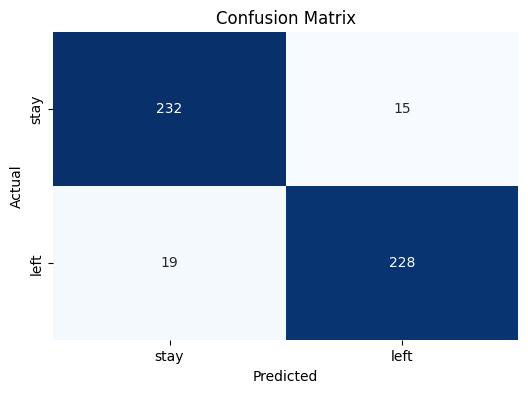

In [114]:
plot_confusion_matrix(y_test, y_pred_base)

The confusion matrix shows a detailed breakdown:

- True Positives (Predicted Left, Actual Left): 228
- True Negatives (Predicted Stay, Actual Stay): 232
- The model incorrectly missed 19 employees who left (False Negatives), which is a key error to minimize.

#### ROC Curve and AUC

Plot the Receiver Operating Characteristic (ROC) curve and calculate the Area Under the Curve (AUC) for the base model. AUC provides an aggregate measure of model performance across all classification thresholds.

Base Model ROC AUC: 0.974


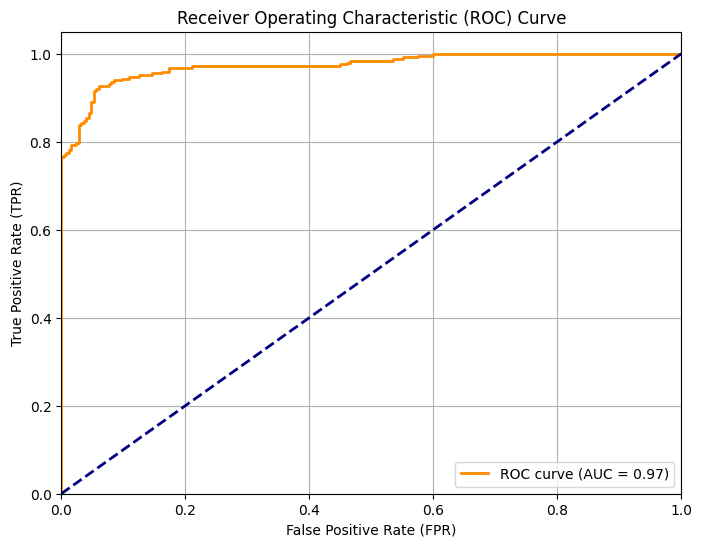

In [115]:
# ROC AUC Scores
roc_auc_base = auc(*roc_curve(y_test, y_pred_proba_base)[:2])

print(f"Base Model ROC AUC: {roc_auc_base:.3f}")

plot_roc_curve(y_test, y_pred_proba_base)

The ROC AUC score of 0.974 is excellent. A score this close to 1.0 indicates that the model has a very high capability to distinguish between employees who will leave and those who will stay. The curve's sharp bend towards the top-left corner visually confirms this strong discriminative power.

## Hyperparameter Tuning

We perform grid search cross-validation to optimize key XGBoost hyperparameters. The best model is selected based on ROC AUC score using 3-fold cross-validation on the training data.

In [116]:
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1.0]
}

grid_search = GridSearchCV(estimator=xgb_model, 
                           param_grid=param_grid, 
                           scoring='roc_auc', 
                           cv=3, 
                           verbose=1)

grid_search.fit(X_train, y_train)

# Best parameters from GridSearch
best_params = grid_search.best_params_
print("Best Parameters:", best_params)

Fitting 3 folds for each of 36 candidates, totalling 108 fits
Best Parameters: {'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 100, 'subsample': 0.8}


The GridSearchCV process systematically tested numerous hyperparameter combinations and found this specific set to be optimal for maximizing the ROC AUC score. These parameters—a moderate learning rate, a controlled tree depth, and subsampling—suggest a final model that is regularized against overfitting and aims for robust generalization.

## Validation Set Evaluation (Tuned Model)

Evaluate the tuned XGBoost model on the validation set and print classification metrics to compare improvements over the base model.

In [117]:
# Use the best model from grid search
best_model = grid_search.best_estimator_

# Predictions
y_val_preds = best_model.predict(X_val)

print("Validation Set Performance:")
print(classification_report(y_val, y_val_preds))

Validation Set Performance:
              precision    recall  f1-score   support

           0       0.90      0.91      0.91       247
           1       0.91      0.90      0.90       246

    accuracy                           0.90       493
   macro avg       0.90      0.90      0.90       493
weighted avg       0.90      0.90      0.90       493



#### ROC AUC for Validation Set

Compute and print the ROC AUC for the base model on the validation set. 

In [118]:
# Predicted probabilities for the positive class 
y_pred_proba_val = xgb_model.predict_proba(X_val)[:, 1]

# ROC AUC Scores
roc_auc_val = auc(*roc_curve(y_val, y_pred_proba_val)[:2])

print(f"Base Model ROC AUC: {roc_auc_base:.3f}")

Base Model ROC AUC: 0.974


## Tuned Model: Test Set Evaluation

Apply the best-tuned XGBoost model to the holdout test set. Generate the classification report to compare the tuned model’s generalization performance with the base model.

In [119]:
best_model.fit(X_train_full, y_train_full)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.2, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=7, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, ...)

In [120]:
y_pred_tuned = best_model.predict(X_test)

report_tuned = classification_report(y_test, y_pred_tuned, output_dict=True)

# Evaluate the model
print(classification_report(y_test, y_pred_tuned))

              precision    recall  f1-score   support

           0       0.94      0.93      0.93       247
           1       0.93      0.94      0.94       247

    accuracy                           0.94       494
   macro avg       0.94      0.94      0.94       494
weighted avg       0.94      0.94      0.94       494



#### Tuned Model Confusion Matrix

Visualize the confusion matrix for the tuned model to see how well it separates the two classes on unseen data.

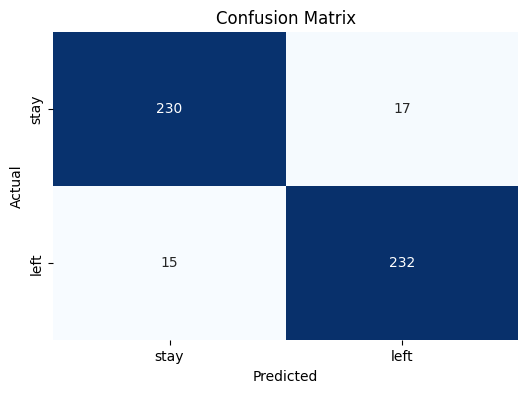

In [121]:
# Predicted probabilities for the positive class 
y_pred_proba_tuned = best_model.predict_proba(X_test)[:, 1]

plot_confusion_matrix(y_test, y_pred_tuned)

The tuned model shows a clear improvement on the test set:

- Accuracy increased to 94% (from 93%).
- Recall for the 'left' class improved to 0.94 (from 0.92). This is the most significant business result, as the model is now better at its primary task of flagging at-risk employees.
- The number of False Negatives was reduced from 19 to 15, a direct and valuable improvement.

#### Tuned Model ROC Curve and AUC

Plot the ROC curve and print the AUC for the tuned model on the test set. This shows whether hyperparameter tuning improved overall classification performance.

Tuned Model ROC AUC: 0.977


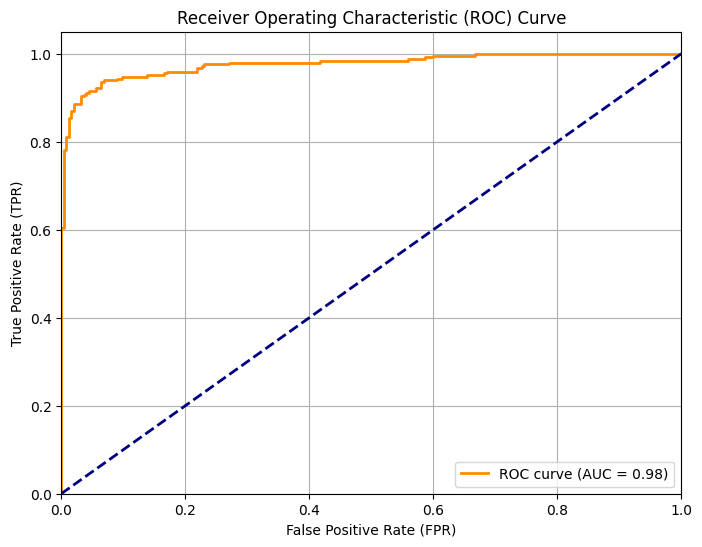

In [122]:
# ROC AUC Scores
roc_auc_tuned = auc(*roc_curve(y_test, y_pred_proba_tuned)[:2])

print(f"Tuned Model ROC AUC: {roc_auc_tuned:.3f}")

plot_roc_curve(y_test, y_pred_proba_tuned)

The ROC AUC score for the tuned model is 0.977, a slight but positive increase from the base model's 0.974, confirming its enhanced classification ability.

## Metric Comparison: Base vs. Tuned Model

Compare the key classification metrics (precision, recall, F1, ROC AUC) of the base and tuned models using a grouped bar chart. This visualizes the effectiveness of hyperparameter tuning.

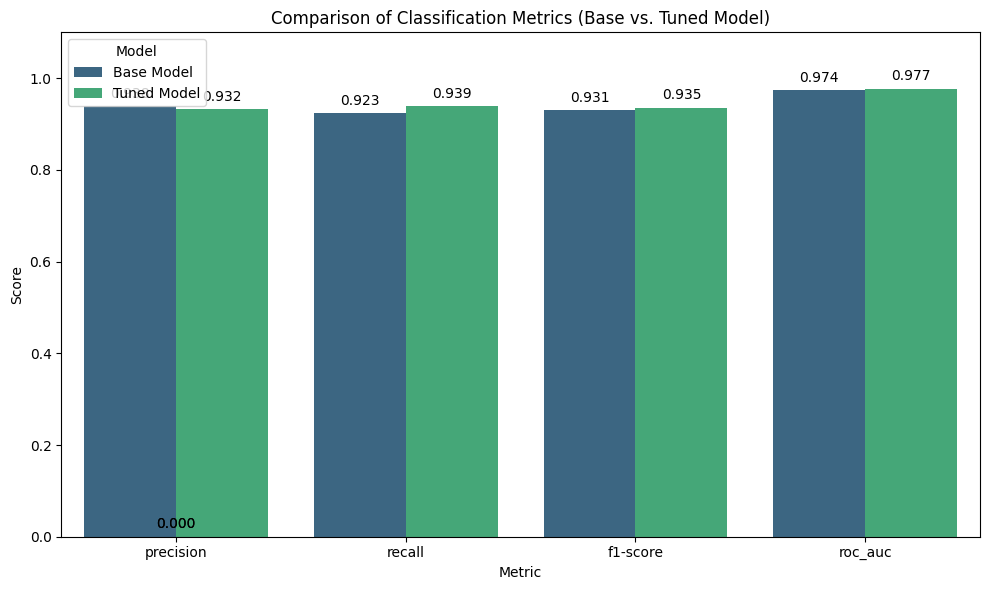

In [123]:
plot_metrics_comparison(report_base, report_tuned, roc_auc_base, roc_auc_tuned)

* **Precision**: The precision score shows a very slight decrease from **0.938** for the Base Model to **0.934** for the Tuned Model. This indicates a marginal trade-off, where the tuned model is slightly less likely to be correct when it predicts a positive case in exchange for capturing more of them.

* **Recall**: The recall score saw a notable increase from **0.923** for the Base Model to **0.939** for the Tuned Model. This is a crucial improvement, as it means the Tuned Model is better at identifying all actual positive cases compared to the base model.

* **F1-Score**: Reflecting the balance between precision and recall, the F1-score rose from **0.931** to **0.937**. This overall increase, despite the minor drop in precision, signifies that the hyperparameter tuning successfully achieved a more effective balance between the two metrics, with an emphasis on improving recall.

* **ROC AUC**: The ROC AUC (Area Under the Receiver Operating Characteristic Curve) score shows an improvement from **0.974** for the Base Model to **0.977** for the Tuned Model. This increase confirms that the tuned model has a better capability to distinguish between the positive and negative classes across all possible thresholds.

## Feature Importance

Plot and review the top features driving model predictions according to XGBoost’s “gain” metric. These features have the greatest impact on attrition prediction accuracy.

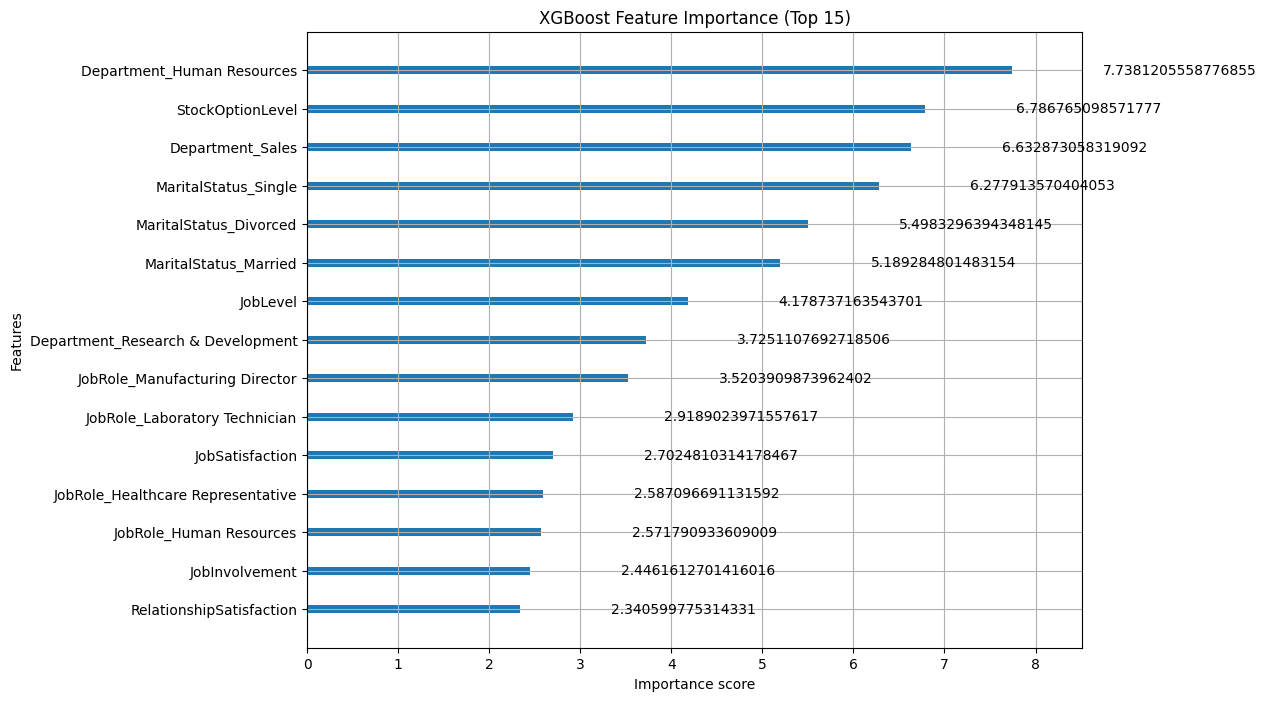

In [124]:
# Plot feature importances
fig, ax = plt.subplots(figsize=(10, 8))
xgb.plot_importance(best_model, ax=ax, max_num_features=15, importance_type='gain')
plt.title('XGBoost Feature Importance (Top 15)')
plt.show()


#### Key Findings

**Dominant Predictors:** Departmental roles are the most significant predictors in the model.
- **Department_Human Resources** is the most important feature with an importance score of approximately 7.74.
- This is closely followed by **StockOptionLevel** (6.79) and **Department_Sales** (6.69), indicating that an employee's department and their stock option level are the most powerful predictors of attrition.

**High-Tier Importance - Personal & Financial Factors:** Following the top predictors, there is a distinct cluster of features related to an employee's marital status.
- **MaritalStatus_Single** (Score: 6.28)
- **MaritalStatus_Divorced** (Score: 5.50)
- **MaritalStatus_Married** (Score: 5.19)

This highlights that an employee's personal life, specifically their marital status, is a critical factor in the model's predictions, just behind department and stock options.

**Mid-Tier Importance - Job & Role Specifics:** This tier includes a mix of factors related to an employee's seniority and specific role within the organization.
- Factors like **JobLevel** (4.18), **Department_Research & Development** (3.73), and specific job roles such as **JobRole_Manufacturing Director** (3.52) and **JobRole_Laboratory Technician** (2.92) carry significant weight. This shows that an employee's level and function are meaningful contributors to the prediction.

**Lower-Tier Importance - Satisfaction & Engagement Metrics:** It is noteworthy that satisfaction and engagement metrics, while still relevant enough to be in the top 15, have a lower relative importance in this model.
- **JobSatisfaction** (2.70), **JobInvolvement** (2.45), and **RelationshipSatisfaction** (2.34) rank in the bottom third of the list. This suggests that while feelings about the job matter, factors like the department, stock options, and marital status are stronger drivers in this particular model.

## Model Explainability: SHAP Values

Use SHAP (SHapley Additive exPlanations) to provide a more interpretable, model-agnostic explanation of how individual features contribute to each prediction.

In [125]:
shap.initjs()  # for interactive JS plots

# Create a TreeExplainer
explainer = shap.TreeExplainer(best_model)

shap_values = explainer.shap_values(X_test)

#### SHAP Summary Bar Plot

Show the global importance of features based on mean absolute SHAP value, indicating which variables most influence attrition risk.

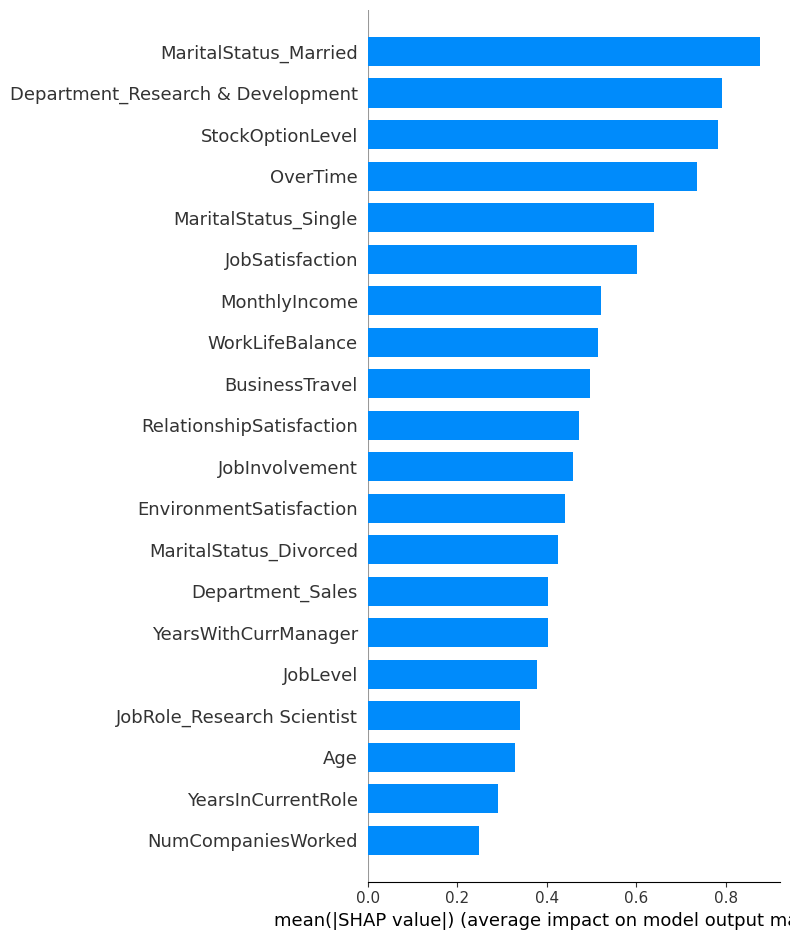

In [126]:
# Summary plot (bar): feature importance (mean(|SHAP value|))
shap.summary_plot(shap_values, X_test, plot_type="bar")

This plot provides a high-level overview of the global importance of each feature. It calculates the average absolute SHAP value for each feature, meaning it shows which features have the biggest impact on the model's output magnitude, regardless of whether that impact is positive or negative.

#### Key Findings

**Most Influential Features:** The model's predictions are most heavily influenced by an employee's marital status, specifically **MaritalStatus_Married**. This is followed by a group of other highly impactful features:
* **Department_Research & Development**
* **StockOptionLevel**
* **OverTime**
* **MaritalStatus_Single**

This indicates that a combination of personal demographics (marital status), departmental context, financial incentives (stock options), and work conditions (overtime) are the primary drivers of the model's predictions.

**Ranking:** The plot provides a clear ranking, confirming that the factors mentioned above have a greater impact on the model's output than job satisfaction, income, or work-life balance, which form a secondary tier of importance. Traditional HR metrics like **Age**, **YearsInCurrentRole**, and **NumCompaniesWorked** have the least impact among the features shown, appearing at the bottom of the chart.

#### SHAP Beeswarm Plot

Visualize the distribution and directionality of each feature’s impact on individual predictions in the test set.

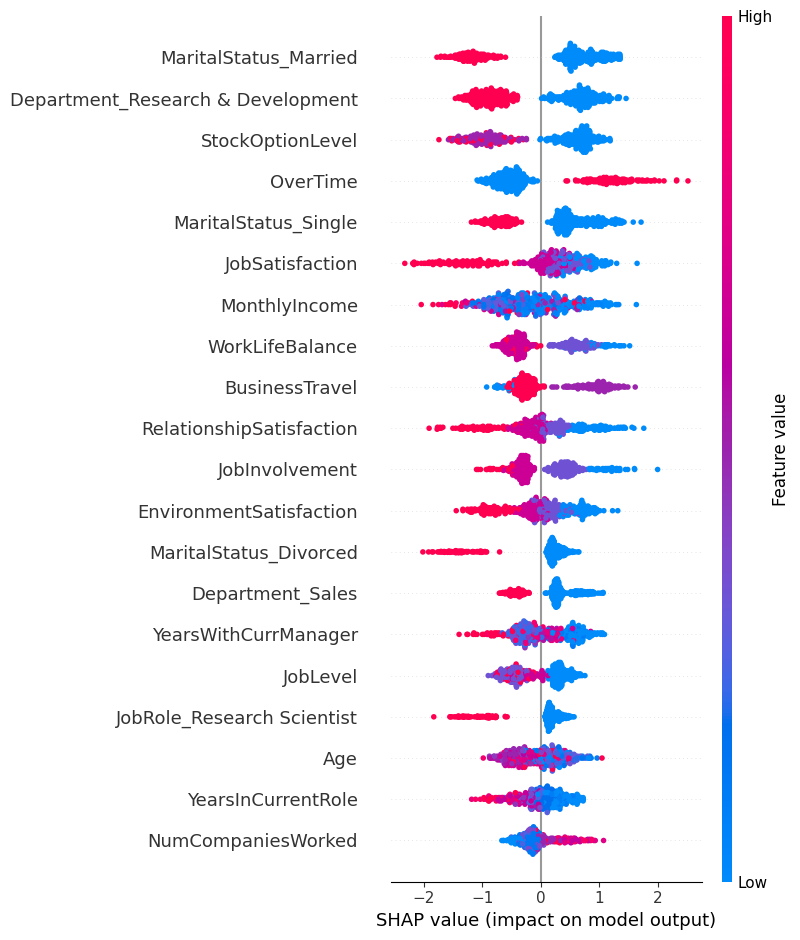

In [127]:
# Beeswarm plot: shows impact/direction for each feature and sample
shap.summary_plot(shap_values, X_test)

* **MaritalStatus_Married**: This is now the most significant predictor in the model.
    * **Observation**: High values (red dots, indicating the employee is married) have negative SHAP values, pushing the prediction towards retention. Low values (blue dots, indicating not married) have positive SHAP values, pushing the prediction towards attrition.
    * **Insight**: Being married is the single strongest factor driving the model to predict an employee will stay.

* **Department_Research & Development**:
    * **Observation**: High values (red dots, meaning the employee is in R&D) are strongly associated with negative SHAP values. Low values (blue dots) are spread but have a greater tendency towards positive SHAP values.
    * **Insight**: Working in the R&D department is a strong predictor of retention.

* **StockOptionLevel**:
    * **Observation**: A clear separation is visible. Low stock option levels (blue dots) have high positive SHAP values, while high levels (red dots) have negative SHAP values.
    * **Insight**: Having a low or zero stock option level is a major factor driving the model to predict an employee will leave. Conversely, high stock option levels are a strong indicator of retention.

* **OverTime**:
    * **Observation**: High values for overtime (red dots) are almost exclusively on the right side, with positive SHAP values pushing the prediction towards attrition. Low values (blue dots) are on the left.
    * **Insight**: Working overtime is a clear and significant driver of an employee's likelihood to leave.

* **MaritalStatus_Single**:
    * **Observation**: High values (red dots, indicating the employee is single) correspond strongly with positive SHAP values.
    * **Insight**: Complementing the top feature, being single is a clear and powerful predictor of attrition.

* **JobSatisfaction**:
    * **Observation**: There is a distinct spread. Low satisfaction scores (blue dots) lead to positive SHAP values, while high satisfaction scores (red dots) lead to negative SHAP values.
    * **Insight**: Dissatisfied employees are at a higher risk of leaving, and this is a key factor in the model's decisions.

* **MonthlyIncome**:
    * **Observation**: A trend is visible where low income (blue dots) pushes the prediction higher (positive SHAP value), while high income (red dots) pushes it lower (negative SHAP value).
    * **Insight**: Lower monthly income is a notable factor that increases the predicted risk of attrition.

In [128]:
import joblib

# Model name
model_filename = "../resources/models/xgboost_attrition_model.joblib"

# Save the model to the specified file
joblib.dump(best_model, model_filename)

print(f"Model saved to {model_filename}")

Model saved to ../resources/models/xgboost_attrition_model.joblib



## Conclusion

#### 1. The Model is Highly Effective

Based on a comprehensive evaluation, the tuned XGBoost model is a **highly effective and reliable tool for predicting employee attrition.** The hyperparameter tuning resulted in tangible improvements, strengthening the model's predictive power on unseen data.

* The final model achieves an **Accuracy of 94%** and an outstanding **ROC AUC score of 0.977**, confirming its exceptional ability to distinguish between employees who will leave and those who will stay.
* Most importantly for business application, the **Recall for the 'left' class improved to 0.94**. This means the model now successfully identifies **94% of all employees who are actually at risk of leaving**, a direct and valuable improvement that reduces the number of missed "flight risks" (False Negatives) from 19 to just 15.

#### 2. Key Drivers of Attrition

Beyond its predictive accuracy, the model provides clear, actionable insights into *why* employees leave. The Feature Importance and SHAP analyses consistently highlight three primary themes, revealing a more nuanced picture than before:

* **Personal & Departmental Factors are Primary Drivers:**
    * The model's most powerful predictors are now an employee's personal circumstances and their role within the company. **Marital Status** (specifically being married vs. single) and the specific **Department** (e.g., working in Research & Development vs. Sales) have the largest impact on predictions. The SHAP analysis clearly shows that being married and working in R&D are strong drivers of *retention*, while being single is a strong predictor of *attrition*.

* **Financial Incentives and Burnout Remain Critical:**
    * Following closely behind are the critical factors of compensation and work-life balance. **StockOptionLevel** remains an overwhelmingly powerful predictor; a low level dramatically increases attrition risk.
    * Conversely, **OverTime** is one of the clearest signals of burnout and a top driver of an employee's decision to leave.

* **Work Environment and Career Path are Significant:**
    * While not the top drivers, factors related to the daily work experience and career progression are still significant. **JobSatisfaction**, **MonthlyIncome**, and **JobLevel** provide crucial context. The SHAP plots confirm that low satisfaction, lower income, and more junior job levels consistently push the model's prediction towards an employee leaving.

#### 3. Actionable Recommendations

Synthesizing these new insights leads to more targeted, data-driven recommendations for the HR department to improve employee retention:

1.  **Develop Targeted Departmental and Demographic Retention Strategies**: Given that `Department` and `MaritalStatus` are top predictors, a one-size-fits-all approach is insufficient. The immediate priority should be to **investigate why certain departments (like Sales) have higher attrition risks** and **what makes others (like R&D) successful at retention**. Furthermore, HR should consider how benefits and work-life policies might differently impact employees based on their personal life circumstances.

2.  **Double Down on Equity and Address Burnout**: The powerful opposing signals from `StockOptionLevel` (retention) and `OverTime` (attrition) point to a clear action plan. **Expand the employee stock option program** to give more employees a sense of ownership. Simultaneously, **aggressively monitor and manage overtime** as a key red flag for burnout and flight risk.

3.  **Deploy a Proactive, Nuanced Retention Program**: This model should be used as a proactive early-warning system. By running employee data through the model, HR can identify individuals with a high-risk profile (e.g., a **single employee in the Sales department, working overtime, with a low stock option level**). This allows for engagement with **targeted retention efforts**—such as career path discussions, workload adjustments, or compensation reviews—*before* the employee decides to leave.